# Training in mini-batches

In [1]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

dtype = torch.double

In [2]:
d = load_diabetes()
len(d.data)

442

In [3]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [4]:
n = len(df)
n_test = int(n*0.20)
n_train = n - n_test
df = df.sample(frac=1) # shuffle data
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [5]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

In [6]:
rf = RandomForestRegressor(n_estimators=500, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 1140.72 validation MSE 3648.21


In [7]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

## Minibatch stochastic gradient descent (SGD)

In [17]:
def sgdtrain(model, X_train, X_test, y_train, y_test,
             learning_rate = .5, nepochs=2000, weight_decay=0, batch_size=32):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    history = []
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            loss = 0
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)
            loss = torch.mean((y_pred - batch_y)**2)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()
        
        epoch_training_loss /= nbatches # average batch loss

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((epoch_training_loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
        
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {epoch_training_loss:12.3f}   test loss {loss_test:12.3f}")

    print(f"BEST MSE test loss {best_loss:.3f}")
    return torch.tensor(history), best_model

Epoch    0 MSE train loss    15518.203   test loss     7021.393
Epoch   10 MSE train loss     2912.810   test loss     3862.548
Epoch   20 MSE train loss     1845.396   test loss     4275.281
Epoch   30 MSE train loss     1284.568   test loss     4375.402
Epoch   40 MSE train loss      672.737   test loss     4479.257
Epoch   50 MSE train loss      729.419   test loss     5457.711
Epoch   60 MSE train loss      257.962   test loss     4952.770
Epoch   70 MSE train loss       83.598   test loss     5011.985
Epoch   80 MSE train loss       52.830   test loss     5044.381
Epoch   90 MSE train loss      164.594   test loss     5023.047
Epoch  100 MSE train loss      135.034   test loss     5091.050
BEST MSE test loss 3355.243
MSE test loss 3355.243


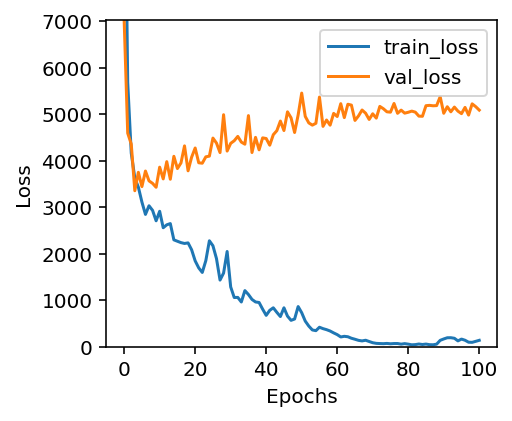

In [18]:
ncols = X.shape[1]
n_neurons = 1000
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.Tanh(),
    nn.Linear(n_neurons, 1)
)

history, best_model = sgdtrain(model, X_train, X_test, y_train, y_test,
                               learning_rate=.05, nepochs=100, weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)
print(f"MSE test loss {loss_test:.3f}")

plot_history(torch.clamp(history, 0, 12000))